Importing data...
Time to create DataFetcher variable :  0.0064487457275390625
Time to get data from DataFetcher :  3.9168319702148438
[2.0000e-01 8.0000e-01 1.7000e+00 ... 1.9381e+03 1.9628e+03 1.9875e+03]


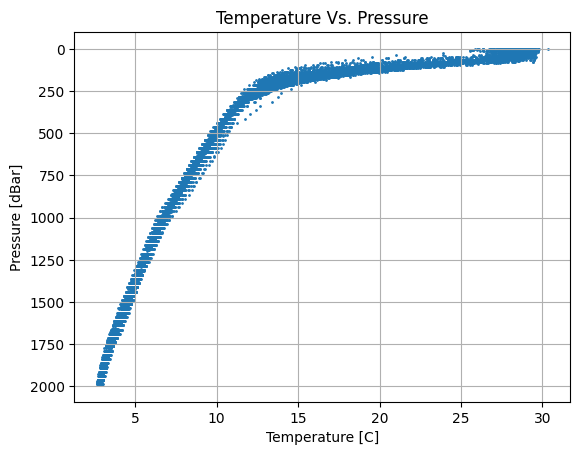

True

In [4]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import time
import argopy


def plot_temp_vs_depth():
    try:
        df_raw = pd.read_csv('data.csv')
    except:
        print("Importing data...")
        t0 = time.time()
        lat_range = [5, 20]     # Latitude: 5°N to 20°N
        lon_range = [80, 95]   # Longitude: 80°E to 95°E
        # ArgoSet = argopy.DataFetcher().region([80, 95, 5, 20, 0, 2000, '2023-12', '2024-03'])
        ArgoSet = argopy.DataFetcher().region([lon_range[0], lon_range[1], lat_range[0], lat_range[1], 0, 2000, '2023-12', '2024-03']) # Bay of Bengal
        print("Time to create DataFetcher variable : ", time.time() - t0)
        df_raw = ArgoSet.data.argo.point2profile().to_dataframe()
        print("Time to get data from DataFetcher : ", time.time() - t0)
        df_raw.to_csv('data_test.csv')

    # Remove rows where temp is None
    df = df_raw.dropna(subset=['TEMP', 'PRES'])

    # Define the variables to work with:
    temp = np.array(df['TEMP'])
    pressure = np.array(df['PRES'])
    print(pressure)

    # Scatter data and add grid
    plt.scatter(temp, pressure, s=1)
    plt.grid(True)
    plt.gca().invert_yaxis()

    # Adding labels to the axes and title
    plt.xlabel('Temperature [C]')
    plt.ylabel('Pressure [dBar]')
    plt.title('Temperature Vs. Pressure')

    # plt.savefig('figures/temp_vs_depth.png')
    plt.show()

    return True

plot_temp_vs_depth()

In [6]:
def load_csv():
    # Load the data from the CSV file
    data = pd.read_csv('/Users/emilywong/Documents/Processing/sioc210_data_project/data_winter.csv')

    # Show the first few rows of the data to confirm it's loaded correctly
    print(data.head())
    return data

def filter_one_float(data):
    # Filter data for one specific float (e.g., PLATFORM_NUMBER 2902766)
    float_data = data[data['PLATFORM_NUMBER'] == 2902766]

    # Sort by pressure (depth) if needed
    float_data = float_data.sort_values(by='PRES')

    print(float_data.head())
    return float_data

all_data = load_csv()
one_float_data = filter_one_float(all_data)

   N_PROF  N_LEVELS  CYCLE_NUMBER DATA_MODE DIRECTION  PLATFORM_NUMBER  \
0      35         0           143         D         A          2902766   
1      35         1           143         D         A          2902766   
2      35         2           143         D         A          2902766   
3      35         3           143         D         A          2902766   
4      35         4           143         D         A          2902766   

   POSITION_QC  PRES  PRES_ERROR  PRES_QC      PSAL  PSAL_ERROR  PSAL_QC  \
0            1   0.2         2.4        1  32.42705        0.01        1   
1            1   0.8         2.4        1  32.42710        0.01        1   
2            1   1.7         2.4        1  32.42800        0.01        1   
3            1   2.5         2.4        1  32.42781        0.01        1   
4            1   3.5         2.4        1  32.43058        0.01        1   

     TEMP  TEMP_ERROR  TEMP_QC  TIME_QC  LATITUDE  LONGITUDE  \
0  28.656       0.002        1    

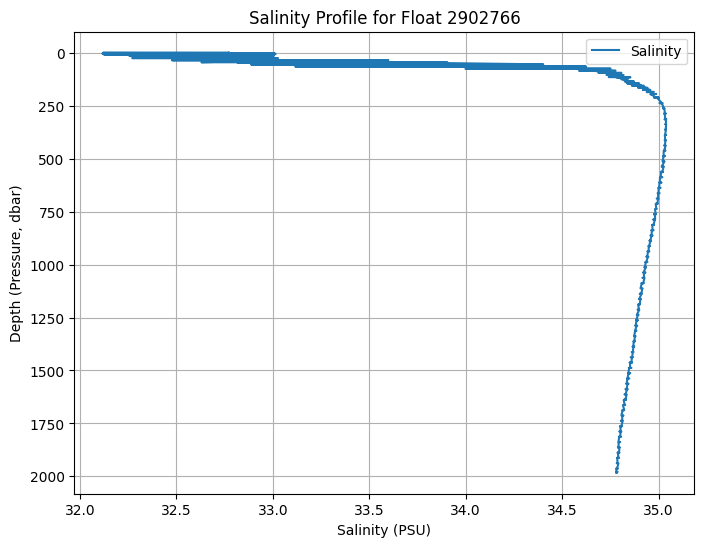

In [7]:
def create_salinity_plot(float_data):

    # Plot Salinity vs Depth
    plt.figure(figsize=(8, 6))
    plt.plot(float_data['PSAL'], float_data['PRES'], label='Salinity')

    # Invert the y-axis so that the surface (shallow depths) is at the top
    plt.gca().invert_yaxis()

    # Label the axes
    plt.xlabel('Salinity (PSU)')
    plt.ylabel('Depth (Pressure, dbar)')

    # Add a title
    plt.title('Salinity Profile for Float 2902766')

    # Show the plot
    plt.legend()
    plt.grid(True)
    plt.show()

create_salinity_plot(one_float_data)

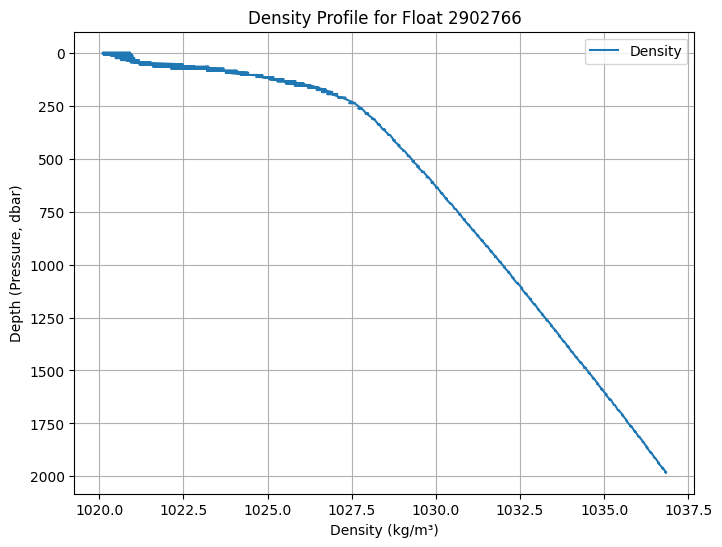

In [9]:
import gsw

def calculate_density(float_data):
    # Sort by pressure (depth)
    float_data = float_data.sort_values(by='PRES')

    # Calculate Absolute Salinity (SA) and Conservative Temperature (CT)
    # Note: gsw expects salinity in Practical Salinity Units (PSU), temperature in degrees Celsius, and pressure in decibars.
    pressure = float_data['PRES'].values
    salinity = float_data['PSAL'].values
    temperature = float_data['TEMP'].values
    latitude = float_data['LATITUDE'].values[0]  # Assuming constant latitude for the float
    longitude = float_data['LONGITUDE'].values[0]  # Assuming constant longitude for the float

    # Calculate Absolute Salinity and Conservative Temperature
    SA = gsw.SA_from_SP(salinity, pressure, longitude, latitude)
    CT = gsw.CT_from_t(SA, temperature, pressure)

    # Calculate density (in-situ density) using the equation of state
    density = gsw.rho(SA, CT, pressure)

    return pressure, density


def create_density_plot(float_data):
    pressure, density = calculate_density(float_data)

    # Plot Density vs Depth
    plt.figure(figsize=(8, 6))
    plt.plot(density, pressure, label='Density')

    # Invert the y-axis so that the surface is at the top
    plt.gca().invert_yaxis()

    # Label the axes
    plt.xlabel('Density (kg/m³)')
    plt.ylabel('Depth (Pressure, dbar)')

    # Add a title
    plt.title('Density Profile for Float 2902766')

    # Show the plot
    plt.legend()
    plt.grid(True)
    plt.show()

create_density_plot(one_float_data)


